In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint, uniform
#from modfunctions import binning, threshold_chart, plot_feature_importance, save_plot, train_model_GridSearch, train_model_RandomizedSearch, plot_roc, export_file, record_results

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.


1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

---

We used the last_trip_date column to feature engineer our levels for active and inactive users. From this we have 37.61% of our 50,000 users labeled as active. String dates were turned into timestamp objects and then further converted to numerical information so the machine learning algorithms can process it. Duplicate values and data inconsistency was checked. NaN values were filled. For EDA, distributions, boxplots, tables, and correlation heatmaps were created. These charts were used to create 2 datasets, one will all features and one with only 'important' features. 

2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

---
We built 4 predictive models to classify user activity. We used Logistic Regression and Random Forest as well as the full and partial datasets for a total of 4 different models. I chose Logistic regression because it is a standard binary classification algorithm and random forest because the features had widely different scales so I thought a tree based model could work better than a 'distance' based one. Some concern is that we scaled the data for both logistic regression and random forest models however scaling is not really needed for tree based models. Our winning model correctly classified 100% of the test set (and consequently had 100% on precision, recall, roc and f1 score). 


3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

---
Ultimate can use this model to target specifically inactive users in order to try and get them to convert. From the feature importance graphs of both the winning model and the runner up (found at the end of this notebook) we can see that 'days_between_signup_and_last_trip' had by far the most significance. This makes sense becase this column was engineered from the same column used to develop the class labels. 'signup_day', 'weekday_pct', and 'avg_rating_by_driver' are the next most important features. In order to improve long term rider retention, Ultimate could maybe offer a free weekday trip to inactive users.

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

## Load Data

In [2]:
df=pd.read_json('./ultimate_challenge/ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


There are 50,000 unique users with 8122, 396,201 nans in the avg_rating_of_driver, phone, avg_rating_by_driver columns respectively.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

## Data Wrangling

We see that the signup_date and last_trip_date columns are strings and not datetime objects. 

In [5]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [6]:
df['signup_date']=pd.to_datetime(df['signup_date'])
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])

Confirming sign up dates are all within the month of January 2014

In [7]:
df.signup_date.value_counts().sort_index()

2014-01-01    1737
2014-01-02    1004
2014-01-03    1213
2014-01-04    1485
2014-01-05    1343
2014-01-06    1763
2014-01-07    1486
2014-01-08    1275
2014-01-09    1433
2014-01-10    2021
2014-01-11    2402
2014-01-12    1334
2014-01-13    1049
2014-01-14    1120
2014-01-15    1110
2014-01-16    1431
2014-01-17    2149
2014-01-18    2948
2014-01-19    2028
2014-01-20    1295
2014-01-21    1234
2014-01-22    1369
2014-01-23    1606
2014-01-24    2284
2014-01-25    2885
2014-01-26    1708
2014-01-27    1236
2014-01-28    1284
2014-01-29    1197
2014-01-30    1471
2014-01-31    2100
Name: signup_date, dtype: int64

The last trip date column ranges from January 1, 2014 to July 1, 2014. We will assume July 1 was the day the data was pulled and will use this date to construct the the column of active/not active passengers. Again, users are considered 'retained if they were “active” (i.e. took a trip) in the preceding 30 days'.

In [8]:
df.last_trip_date.value_counts().sort_index()

2014-01-01     128
2014-01-02     180
2014-01-03     128
2014-01-04     199
2014-01-05     270
              ... 
2014-06-27    1120
2014-06-28    1679
2014-06-29    2036
2014-06-30    1408
2014-07-01     548
Name: last_trip_date, Length: 182, dtype: int64

Create boolean active/not active column based on whether the user has taken a ride in the preceding 30 days from 2014-06-01 to 2014-07-01. True means active and False means not active. Also change the ultimate_black_user column from True/False to 1/0

In [9]:
df['active']=(df.last_trip_date>='2014-06-01').astype(int)
df['ultimate_black_user']=df['ultimate_black_user'].astype(int)

#### Check for Duplicates

There don't seem to be too many duplicates or anything we should be concerned about. With 50,000 users in our dataset, it seems plausable to have a few duplicates.

In [10]:
df[df.duplicated(keep='first')]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,1,0.0,6.25,5.0,0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,1,0.0,2.33,5.0,0
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,0,100.0,8.08,5.0,0
34641,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,1,0.0,1.44,5.0,0
36627,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,0,0.0,3.54,5.0,0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,0,100.0,0.00,5.0,0
42025,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,0,0.0,0.01,5.0,0
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,0,100.0,3.06,5.0,0


#### Inconsistencies

Last trip date should not occur before sign up date. There are no inconsistencies.

In [11]:
df[df.signup_date > df.last_trip_date]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active


#### Extracting Information from Timestamp Columns

Because timestamp objects don't work in most if not all machine learning algorithms, we need to extract meaningful information from the timestamps. 

The signup_date column take place in only the month of January 2014, we can simply extract the 'day' data from this column.

Because we used the last_trip_date column to develop our labels, we should not use this column as part of our features. This is because the last_trip_date column contains all the information to recontruct the active column.

In [12]:
df['signup_day']=df['signup_date'].dt.day
df['days_between_signup_and_last_trip'] = (df['last_trip_date'] - df['signup_date']).dt.total_seconds() / (24 * 60 * 60)

df=df.drop(columns=['signup_date', 'last_trip_date'], axis=1)
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,signup_day,days_between_signup_and_last_trip
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,25,143.0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,29,96.0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0,6,1.0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,10,170.0
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0,27,47.0


#### Handling NaN Values

There are 3 columns with missing values: avg_rating_of_driver, phone, and avg_rating_by_driver.

In [13]:
df.isna().sum()

city                                    0
trips_in_first_30_days                  0
avg_rating_of_driver                 8122
avg_surge                               0
phone                                 396
surge_pct                               0
ultimate_black_user                     0
weekday_pct                             0
avg_dist                                0
avg_rating_by_driver                  201
active                                  0
signup_day                              0
days_between_signup_and_last_trip       0
dtype: int64

We will inpute the missing values by grouping the dataframe by the 'active' column and randomly drawing values from each dataframe's respective column to fill in NaNs. 

In [14]:
def fill_nan_with_distribution(x, series):
    if pd.isnull(x):
        return np.random.choice(series)
    else:
        return x

np.random.seed(123)
columns=['avg_rating_of_driver','phone','avg_rating_by_driver']
df_0=df[df['active']==0]
df_1=df[df['active']==1]
for df in [df_0, df_1]:
    for column in columns:
        df[column]=df[column].apply(fill_nan_with_distribution, series=df[column].dropna());
df=pd.concat([df_0,df_1])

In [15]:
df.isna().sum()

city                                 0
trips_in_first_30_days               0
avg_rating_of_driver                 0
avg_surge                            0
phone                                0
surge_pct                            0
ultimate_black_user                  0
weekday_pct                          0
avg_dist                             0
avg_rating_by_driver                 0
active                               0
signup_day                           0
days_between_signup_and_last_trip    0
dtype: int64

## EDA

About 40% of users are considered active

In [16]:
df.active.value_counts()

0    31196
1    18804
Name: active, dtype: int64

#### Tables for Categorical Variables

City of account creation seems like it has a strong correlation with active users

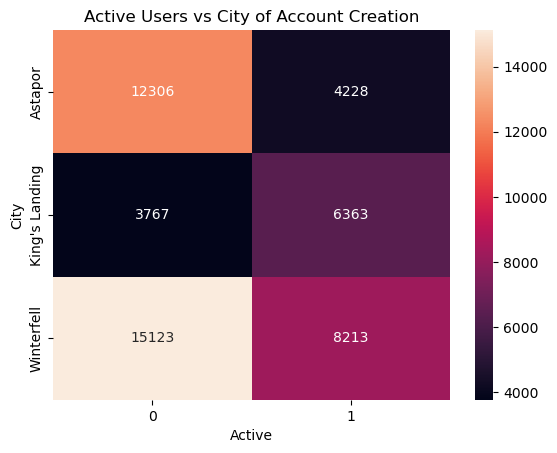

In [17]:
cross_tab = pd.crosstab(df['city'], df['active'])
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.ylabel('City')
plt.xlabel('Active')
plt.title('Active Users vs City of Account Creation')
plt.show()

Android users tend to be inactive while iphone users tend to be more active

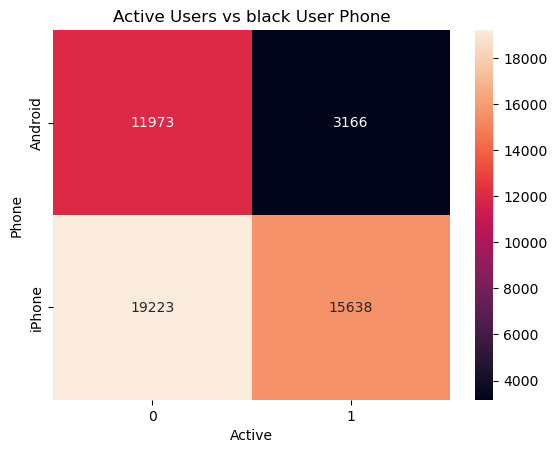

In [18]:
cross_tab = pd.crosstab(df['phone'], df['active'])
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.ylabel('Phone')
plt.xlabel('Active')
plt.title('Active Users vs black User Phone')
plt.show()

If you were not an ultimate black user within the first 30 days of signing up, you are likely to be inactive. If you were an ultimate black user within the first 50 days of signingup, theres a ~ 50/50 chance of you being active

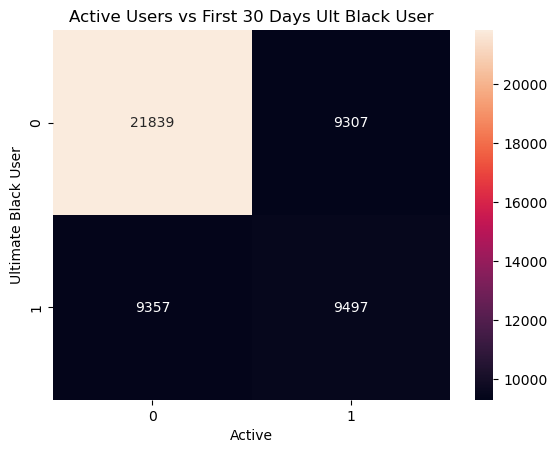

In [19]:
cross_tab = pd.crosstab(df['ultimate_black_user'], df['active'])
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.ylabel('Ultimate Black User')
plt.xlabel('Active')
plt.title('Active Users vs First 30 Days Ult Black User')
plt.show()

#### Boxplots for Continuous Variables

For the non-categorical variables, I made a boxplot for each against our response variable of 'active'
The variables trips_in_first_30_days, avg_surge, and avg_distance don't seem important in deciding active or not active.

* People who are active tend to have slightly lower average driver rating
* Active users have slightly higher average surge multipliers
* Active users have a decent number of people who use ultimate during surge pricing. Almost all inactive users never use surge pricing.
* Active users have a tighter weekday percentage spread than inactive users. There are a lot of inactive users with 100% weekday percentage.
* Active users tend to have lower rating by drivers than inactive users.
* signup_day does not seem to have an effect on user activity
* There is a strong relationship between 'days_between_signup_and_last_trip' and 'active'

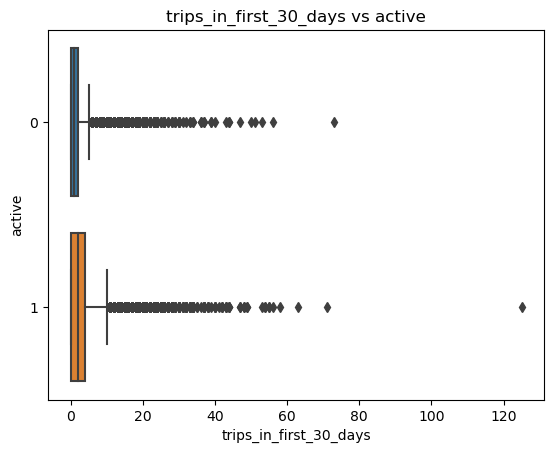

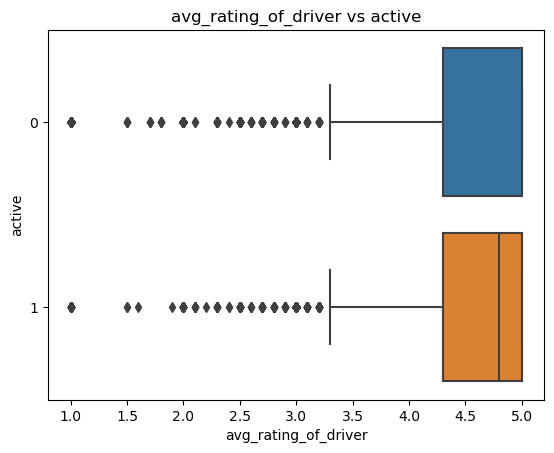

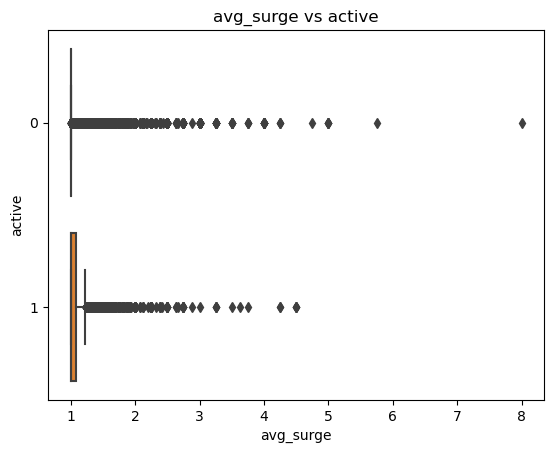

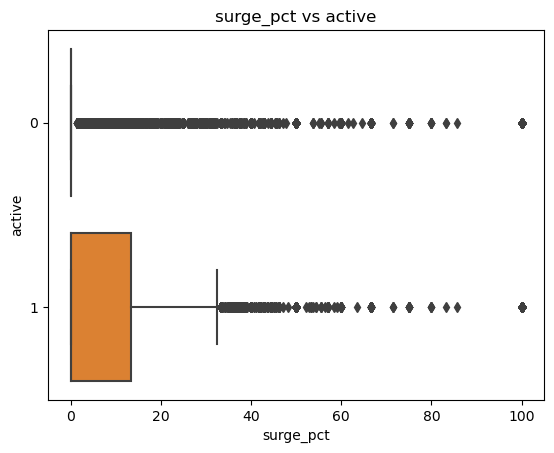

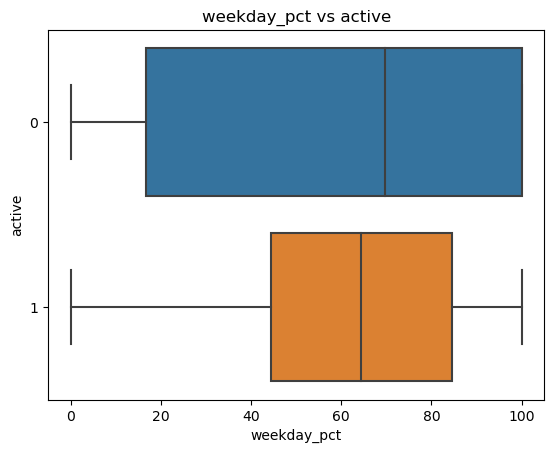

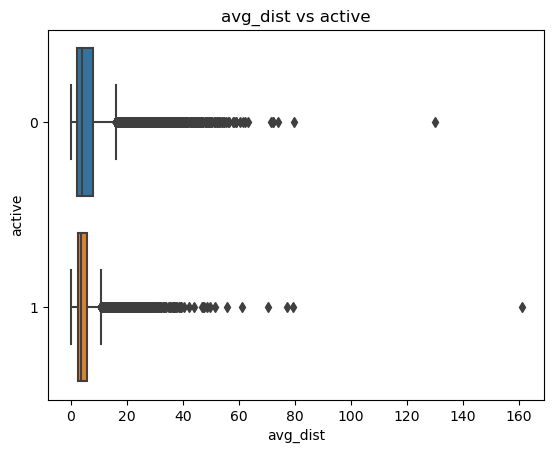

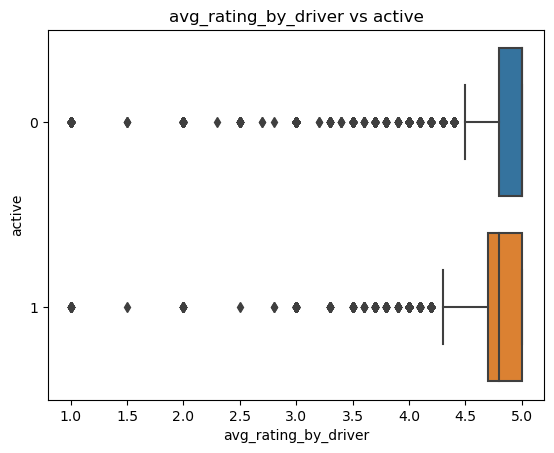

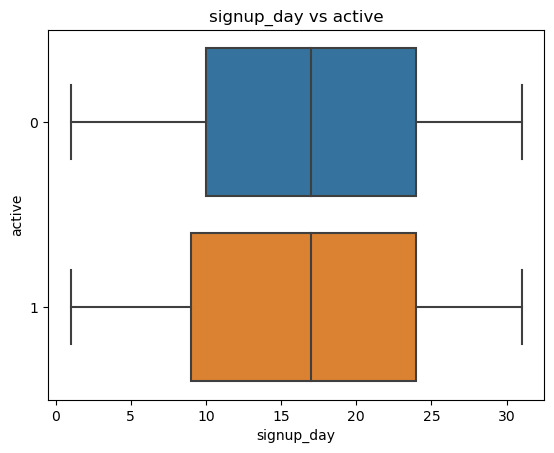

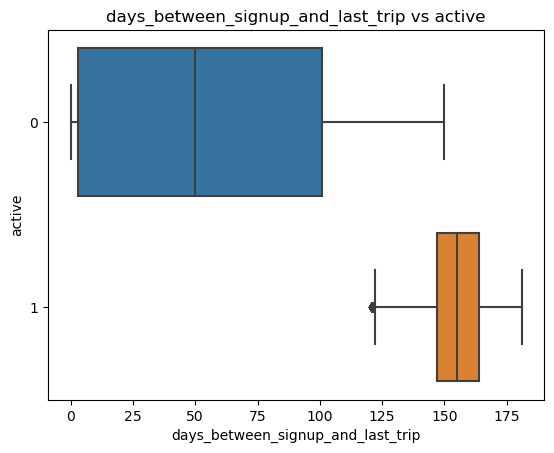

In [20]:
for feature in df.columns:
    if feature in ('city','signup_date', 'last_trip_date', 'phone', 'ultimate_black_user', 'active'):
        continue
    sns.boxplot(data=df, x=feature, y=df['active'].astype('category'), saturation=.7)
    plt.title(feature+ ' vs active')
    plt.show()

#### Feature Distributions

A lot of the features have a skewed distribution. There are no extreme outliers that would suggest bad data.

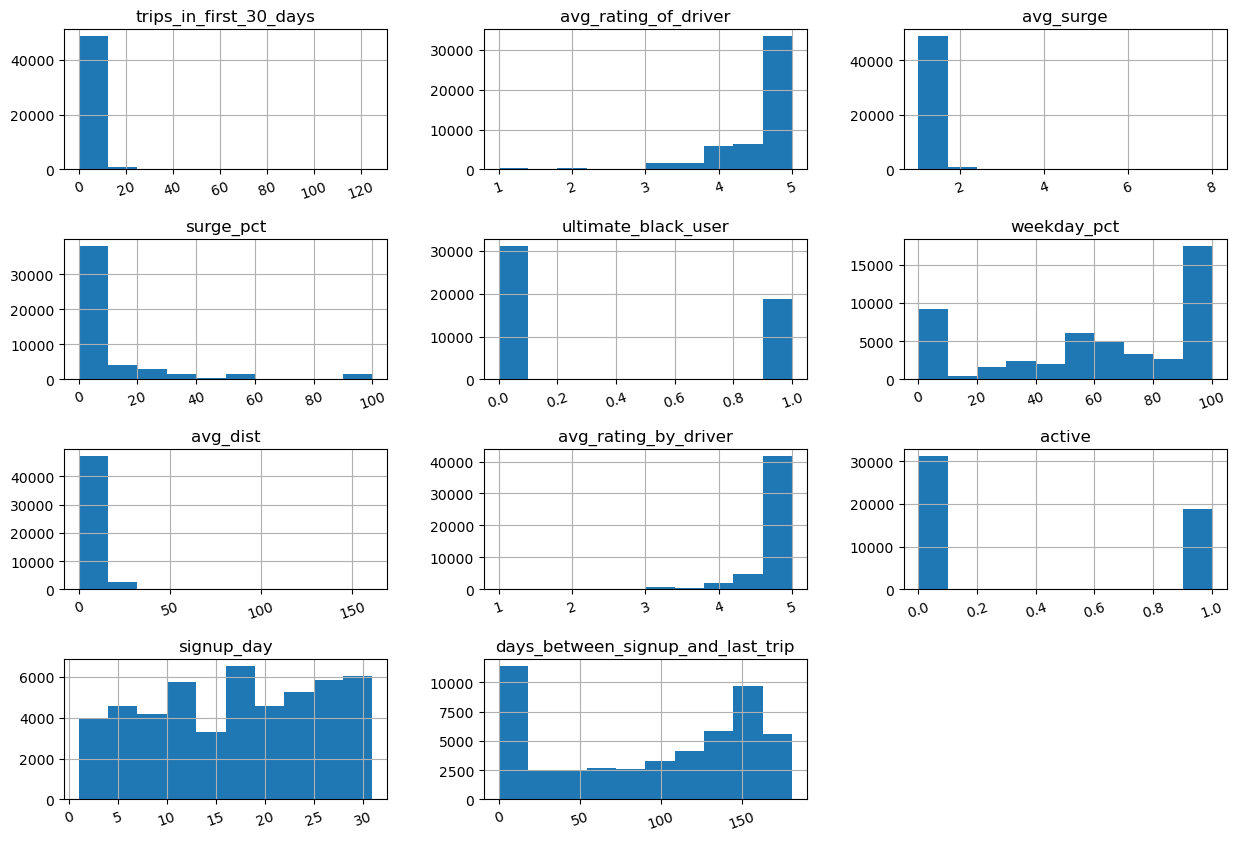

In [21]:
df.hist(figsize=(15,10), xrot=19)
plt.subplots_adjust(hspace=0.5);

#### Correlation Heatmap

We can see that a lot of the features are not strongly correlated with active. The strongest features are trips_in_first_30_days, ultimate_black_user, and days_between_last_trip_and_signup.

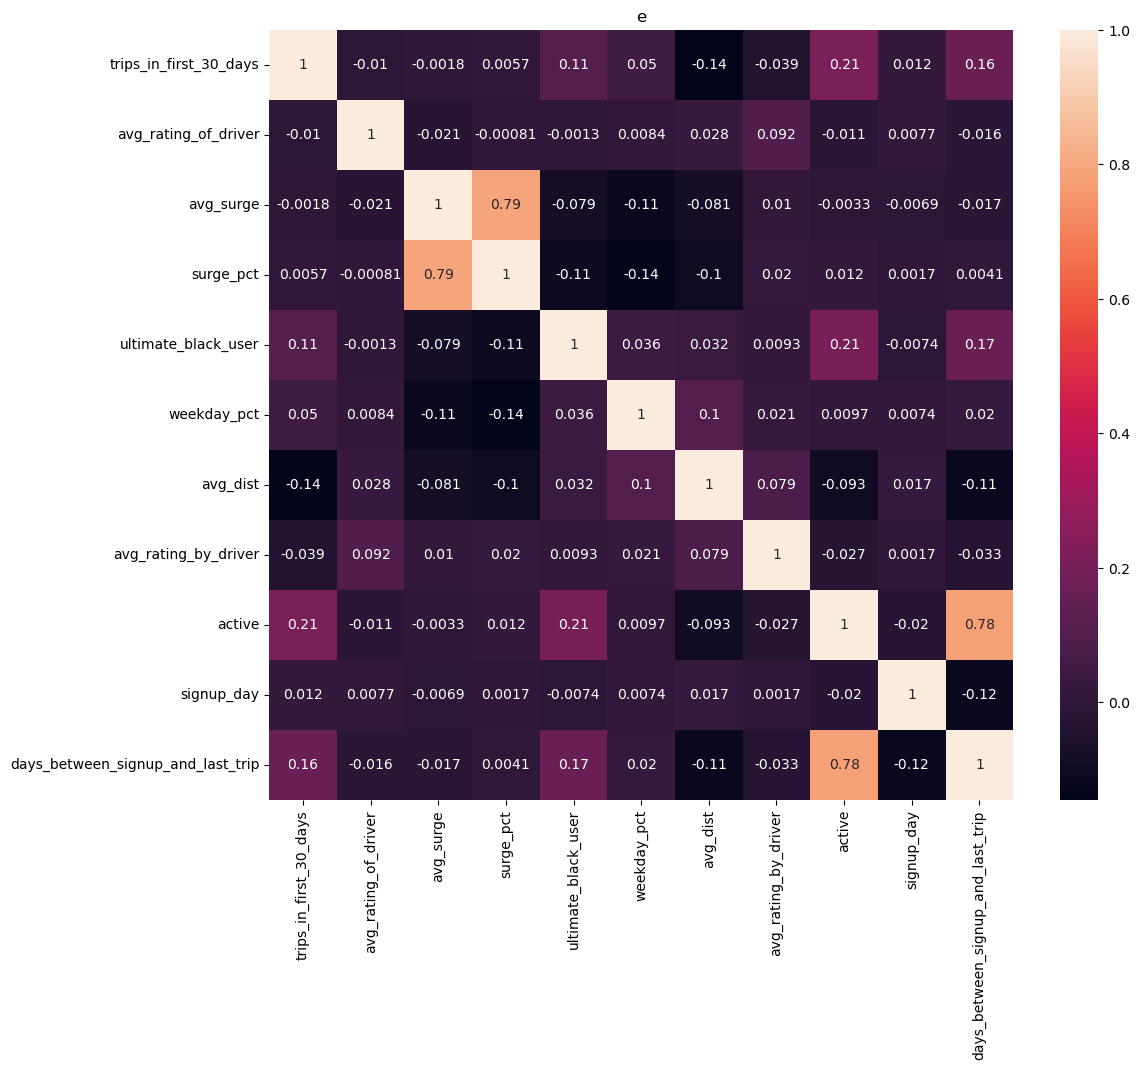

In [22]:
plt.subplots(figsize=(12,10))
plt.title('e')
sns.heatmap(df.drop(columns=['city', 'phone']).corr(), annot=True);

## Preprocessing

#### Dummy Encoding

In [24]:
dummies=pd.get_dummies(df[['city', 'phone']], drop_first=True, dtype=int)
dummies=pd.concat([df, dummies], axis=1)
dummies.drop(['city', 'phone'],axis=1, inplace=True)
dummies.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,signup_day,days_between_signup_and_last_trip,city_King's Landing,city_Winterfell,phone_iPhone
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,29,96.0,0,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,6,1.0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,27,47.0,0,1,0
6,1,5.0,1.00,0.0,0,100.0,3.95,4.0,0,24,1.0,0,0,0
7,2,5.0,1.00,0.0,0,100.0,2.04,5.0,0,28,1.0,0,1,1


#### Scaling Data

We will scale the data using RobustScalar because our features are not normally distributed. We make sure to fit the RobustScalar on training data only to prevent data leakage.

In [25]:
def scale_data(df, y, ignore_columns):
    '''
    Does train test split and scales data
    ---Parameters---
    df (pandas DataFrame) data with response variable
    y (str) name of column with response variable
    ignore_columns (list of str) which columns to ignore when scaling
    ---Returns---
    train, test (pandas DataFrames) reconstructed train and test dataframes
    '''
    #X and y
    response=df[y]
    X=df.drop(y, axis=1)
    #Train test split
    X_train, X_test, y_train, y_test=train_test_split(X, response, test_size=.2,random_state=123)
    
    X_categorical_train=X_train[ignore_columns]
    X_categorical_test=X_test[ignore_columns]
    
    X_cont_train=X_train.drop(ignore_columns, axis=1)
    X_cont_test=X_test.drop(ignore_columns, axis=1)
    #Record column names and indexes
    X_cont_columns=X_cont_train.columns
    X_train_index=X_cont_train.index
    X_test_index=X_cont_test.index
    #RobustScaler
    robust_transformer = RobustScaler()
    X_cont_train=robust_transformer.fit_transform(X_cont_train)
    X_cont_test=robust_transformer.transform(X_cont_test)
    #Reconstruct DataFrame
    train=pd.DataFrame(X_cont_train, columns=X_cont_columns, index=X_train_index)
    train=pd.concat([train, X_categorical_train], axis=1)
    train[y]=y_train
    
    test=pd.DataFrame(X_cont_test, columns=X_cont_columns, index=X_test_index)
    test=pd.concat([test, X_categorical_test], axis=1)
    test[y]=y_test
    
    return train, test

In [26]:
train, test =scale_data(dummies, 'active', ['ultimate_black_user', "city_King's Landing", 'city_Winterfell', 'phone_iPhone'])

## Modeling

In [27]:
y_train=train['active']
X_train_full=train.drop(['active'], axis=1)
X_train_partial=train[['trips_in_first_30_days','ultimate_black_user', 'days_between_signup_and_last_trip', 'avg_dist',"city_King's Landing", 'city_Winterfell', 'phone_iPhone']]

y_test=test['active']
X_test_full=test.drop(['active'], axis=1)
X_test_partial=test[['trips_in_first_30_days','ultimate_black_user', 'days_between_signup_and_last_trip', 'avg_dist',"city_King's Landing", 'city_Winterfell', 'phone_iPhone']]

scores=[]

In [28]:
def train_model_GridSearch(X_train, y_train, steps, parameters):
    '''
    Trains a model using GridSearchCV
    ---Parameters---
    X_train (pandas DataFrame) training features
    y_train (pandas Series) training target class
    steps (list) steps used in pipeline
    parameters (dictionary) dictionary of hyperparameters to tune using GridSearchCV
    ---Returns---
    cv (sklearn classifier) fitted model
    '''
    pipe=Pipeline(steps)
    kf=KFold(n_splits=5, shuffle=True, random_state=123)
    cv=GridSearchCV(pipe,param_grid=parameters,cv=kf,scoring='accuracy', n_jobs=-1)
    cv.fit(X_train,y_train)
    return cv

In [29]:
def train_model_RandomizedSearch(X_train, y_train, steps, parameters):
    '''
    Trains a model using RandomizedSearchCV
    ---Parameters---
    X_train (pandas DataFrame) training features
    y_train (pandas Series) training target classes
    steps (list) steps used in pipeline
    parameters (dictionary) dictionary of hyperparameters to tune using GridSearchCV
    ---Returns---
    cv (sklearn classifier) fitted model
    '''
    pipe=Pipeline(steps)
    kf=KFold(n_splits=5, shuffle=True, random_state=123)
    cv=RandomizedSearchCV(pipe, param_distributions=parameters, cv=kf, scoring='accuracy', n_iter=50, random_state=123, n_jobs=-1)
    cv.fit(X_train,y_train)
    return cv

#### Logistic Regression with Full Features

In [30]:
LR_steps=[('LogReg', LogisticRegression(solver='liblinear', random_state=123))]
LR_parameters= {'LogReg__penalty': ['l1', 'l2'],
                'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
               }
LR_cv_full=train_model_GridSearch(X_train_full, y_train, LR_steps, LR_parameters)
LR_cv_full.best_params_

{'LogReg__C': 10.0, 'LogReg__penalty': 'l1'}

In [31]:
LR_cv_full.best_score_

1.0

In [32]:
def record_results(model_name, cv, X_test, y_test):
    '''
    Records metrics for given classifier
    ---Parameters---
    model_name (str) name of model
    cv (sklearn classifier) fitted classifier
    X_test (pandas DataFrame) test features
    y_test (pandas Series) test target classes
    threshold (float) probability threshold for positive class
    ---Returns---
    list of metrics for classifier 
    '''
    y_pred=(cv.predict(X_test))
    y_prob=cv.predict_proba(X_test)[:,1]
    f1=f1_score(y_test,y_pred, average='binary')
    test_acc=accuracy_score(y_test,y_pred)
    roc=roc_auc_score(y_test, y_prob)
    precision= precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    return [model_name, f1, test_acc, roc, precision, recall]

In [33]:
LR_results_full=record_results('Logistic Regression Full Features', LR_cv_full, X_test_full, y_test)
scores.append(LR_results_full)

#### Logistic Regression with Partial Features

In [34]:
LR_steps=[('LogReg', LogisticRegression(solver='liblinear', random_state=123))]
LR_parameters= {'LogReg__penalty': ['l1', 'l2'],
                'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
               }
LR_cv_partial=train_model_GridSearch(X_train_partial, y_train, LR_steps, LR_parameters)
LR_cv_partial.best_params_

{'LogReg__C': 1.0, 'LogReg__penalty': 'l2'}

In [35]:
LR_cv_partial.best_score_

0.9602499999999999

In [36]:
LR_results_partial=record_results('Logistic Regression Partial Features', LR_cv_partial, X_test_partial, y_test)
scores.append(LR_results_partial)

#### Random Forest with Full Features

In [37]:
num_features_full=X_train_full.shape[1]
RF_steps=[('randomForest', RandomForestClassifier(random_state=123))]
RF_parameters={'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(3,20),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features_full)+1,
             'randomForest__criterion': ['gini', 'entropy']
              }
RF_cv_full=train_model_RandomizedSearch(X_train_full, y_train, RF_steps, RF_parameters)
RF_cv_full.best_params_

{'randomForest__criterion': 'gini',
 'randomForest__max_depth': 17,
 'randomForest__max_features': 12,
 'randomForest__min_samples_leaf': 4,
 'randomForest__min_samples_split': 5,
 'randomForest__n_estimators': 226}

In [38]:
RF_cv_full.best_score_

0.999225

In [39]:
RF_results_full=record_results('Random Forest Full Features', RF_cv_full, X_test_full, y_test)
scores.append(RF_results_full)

#### Random Forest with Partial Features

In [40]:
num_features_full=X_train_partial.shape[1]
RF_steps=[('randomForest', RandomForestClassifier(random_state=123))]
RF_parameters={'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(3,20),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features_full)+1,
             'randomForest__criterion': ['gini', 'entropy']
              }
RF_cv_partial=train_model_RandomizedSearch(X_train_partial, y_train, RF_steps, RF_parameters)
RF_cv_partial.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': 6,
 'randomForest__max_features': 4,
 'randomForest__min_samples_leaf': 6,
 'randomForest__min_samples_split': 3,
 'randomForest__n_estimators': 123}

In [41]:
RF_cv_partial.best_score_

0.9613000000000002

In [42]:
RF_results_partial=record_results('Random Forest Partial Features', RF_cv_partial, X_test_partial, y_test)
scores.append(RF_results_partial)

#### Model Scores

In [43]:
results= pd.DataFrame(scores, columns=['Model Name', 'f1 score', 'test_acc', 'roc','precision', 'recall'])
results

,Model Name,f1 score,test_acc,roc,precision,recall
0,Logistic Regression Full Features,1.000000,1.0000,1.000000,1.000000,1.000000
1,Logistic Regression Partial Features,0.945138,0.9578,0.994102,0.941954,0.948343
2,Random Forest Full Features,0.999348,0.9995,0.999998,0.999739,0.998956
3,Random Forest Partial Features,0.944128,0.9568,0.994370,0.936137,0.952257


Winner: Logistic Regression Full Features

Runner Up: Random Forest Full Features

In [44]:
def plot_feature_importance(importance, names, model_name):
    '''
    Visualizes a bar plot showing feature importance
    ---Parameters---
    importance (np array, pd series, list) coefficients or values of feature importance
    names (np array, pd series, list of str) corresponding feature names
    ---Returns---
    bp (sns.barplot object)
    '''
    data={'feature_names':names, 'feature_importance':importance}
    df=pd.DataFrame(data, columns=['feature_names', 'feature_importance'])
    df['abs']=df['feature_importance'].apply(lambda x: abs(x))
    df.sort_values(by=['abs'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    bp=sns.barplot(data=df, x='feature_importance', y='feature_names')
    plt.tight_layout(pad=1.6)
    plt.title(model_name + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    return bp

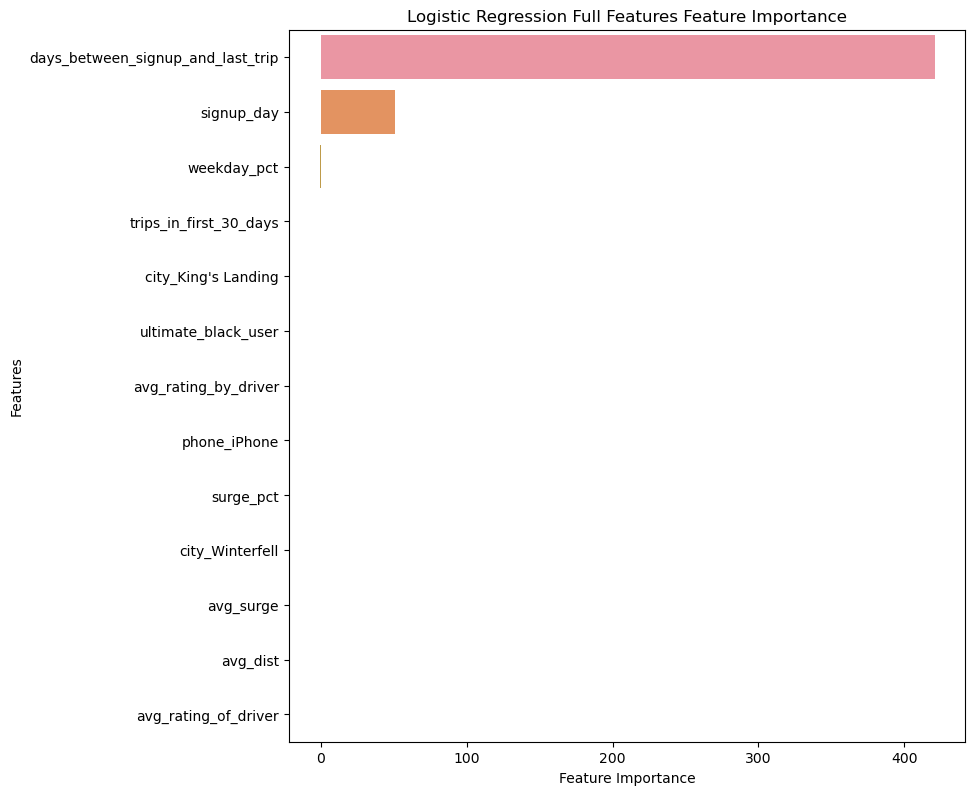

In [45]:
importance=LR_cv_full.best_estimator_.steps[0][1].coef_[0]
pfi=plot_feature_importance(importance, X_train_full.columns, 'Logistic Regression Full Features')

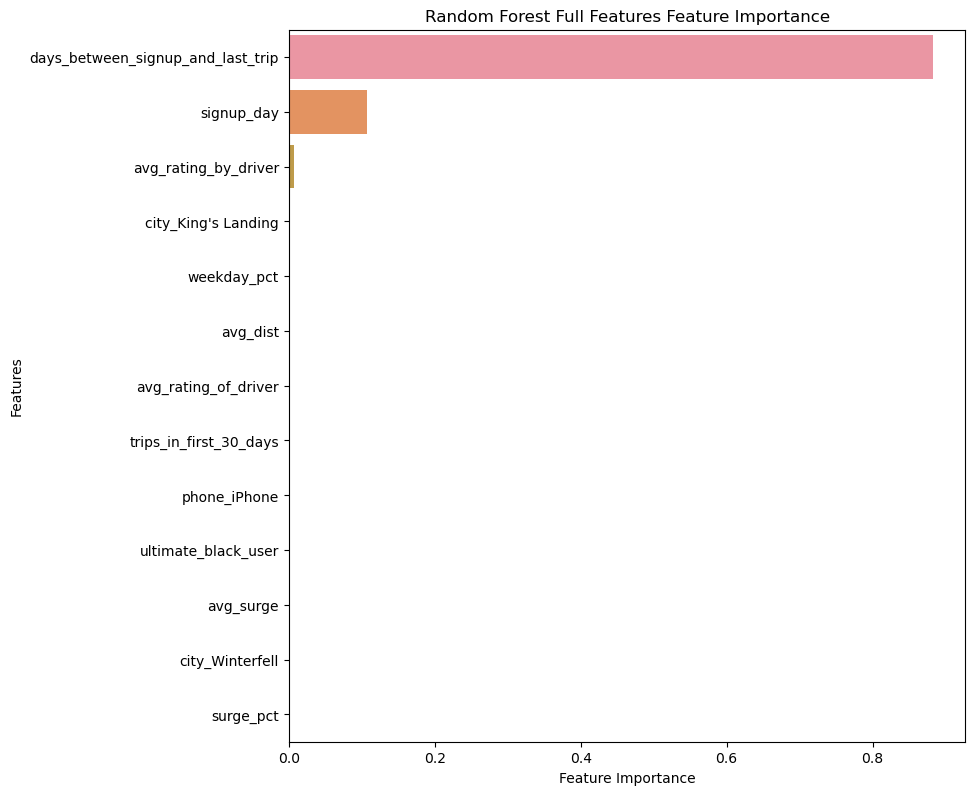

In [47]:
importance=RF_cv_full.best_estimator_.steps[0][1].feature_importances_
pfi=plot_feature_importance(importance, X_train_full.columns, 'Random Forest Full Features')